In [ ]:
!pip install faiss-cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 48.8 MB/s eta 0:00:00


In [ ]:
!pip install gensim

## Word2vec

In [1]:
import gensim
import nltk

In [2]:
text_data = """Machine learning is a branch of artificial intelligence and computer science. 
Machine learning focuses on the use of data and algorithms to imitate the way that humans learn."""

# Split the text into sentences
sentences = nltk.sent_tokenize(text_data)

# Convert sentences to words
sentences = [gensim.utils.simple_preprocess(s) for s in sentences]

In [3]:
sentences 

[['machine',
  'learning',
  'is',
  'branch',
  'of',
  'artificial',
  'intelligence',
  'and',
  'computer',
  'science'],
 ['machine',
  'learning',
  'focuses',
  'on',
  'the',
  'use',
  'of',
  'data',
  'and',
  'algorithms',
  'to',
  'imitate',
  'the',
  'way',
  'that',
  'humans',
  'learn']]

From the text corpus, we can train the word2vec model using gensim. We can set different parameters for the word2vec model.

In [4]:
# Build the word2vec model
w2v = gensim.models.Word2Vec(
    sentences=sentences,  # input data
    vector_size=128,  # size of the vectors
    window=5,  # window size
    min_count=1,  # minimum count of words
    epochs=3,  # number of iterations
    hs=0,  # Turn off hierarchical softmax and use negative sampling
    sg=1,  # Use skip-gram instead of CBOW
)

In [5]:
vocab = list(w2v.wv.key_to_index)
emb = w2v.wv[vocab]

In [6]:
emb.shape

(22, 128)

After training process, we will get a high-dimensional vector space for text corpus. We can project this vector space into 2D or 3D to further observe the embedding relationship.

/Users/visionwang/miniforge3/envs/netdatasci/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


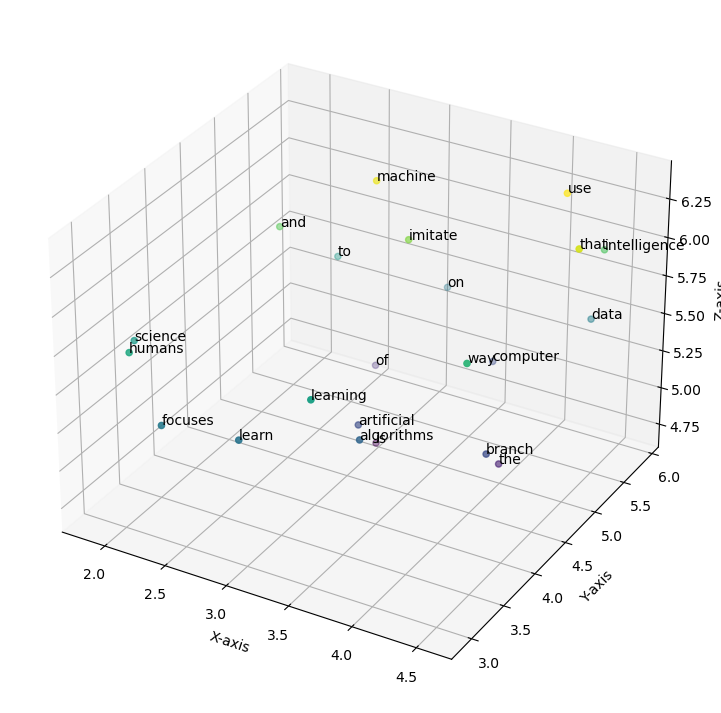

In [8]:
import umap
import matplotlib.pyplot as plt

# Reduce dimensionality
reducer = umap.UMAP(n_components=3, random_state=42, n_neighbors=5, metric="cosine")
xyz = reducer.fit_transform(emb)

# Create a 3D scatter plot with Seaborn
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')
x=xyz[:, 0]
y=xyz[:, 1]
z=xyz[:, 2]
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
for i, c in enumerate(vocab):
    ax.text(xyz[i,0],xyz[i,1],xyz[i,2],  '%s' % c, size=10)
plt.show()

## Word2vec Question and Answer Chatbot Application

In this exercise, we will create a Q-A chatbot only based on question search.

### Component 1: data preparation

In [ ]:
import pandas as pd

df = pd.read_csv("/content/sample_data/Question_Answer_Dataset_v1.2_S10.csv")
df.head()

In [ ]:
df.isna().sum()

ArticleTitle                0
Question                    0
Answer                      0
DifficultyFromQuestioner    0
DifficultyFromAnswerer      0
ArticleFile                 0
dtype: int64

In [ ]:
df["Answer"][12]

'Napoleon'

In [ ]:
df["Answer"][14]

'1819'

In our data, there are both text and numbers. We need to generate a set of corpus including both of them. Based on this, we cannot use gensim.utils.simple_preprocess to prepare corpus. Here, we will use regular expression. 

In [ ]:
import re

# initializing string
test_str = "Gfg, is best : for ! Geeks ;? 123 a 9..."

# printing original string
print("The original string is : " + test_str)

# Removing punctuations in string
res = re.sub(r'[^\w\s]', '', test_str)
# Replace all sequences of two or more spaces with a single space.
res = re.sub(' +', ' ', res)

# printing result
print("The string after punctuation filter : ", res.strip().split(" "))

The original string is : Gfg, is best : for ! Geeks ;? 123 a 9...
The string after punctuation filter :  ['Gfg', 'is', 'best', 'for', 'Geeks', '123', 'a', '9']


### Component 2: word2vec model training

In [ ]:
# train word2vec model with all questions

# Split the text into sentences
sentences = df["Question"].to_list()

def token(text):
  # Removing punctuations in string
  res = re.sub(r'[^\w\s]', '', text)
  # Replace all sequences of two or more spaces with a single space.
  res = re.sub(' +', ' ', res)
  # lower case
  res = res.lower()
  return res.strip().split(" ")

# Convert sentences to words
sentences = [token(text) for text in sentences]

In [ ]:
w2v = gensim.models.Word2Vec(
    sentences=sentences,  # input data
    vector_size=128,  # size of the vectors
    window=5,  # window size
    min_count=1,  # minimum count of words
    epochs=3,  # number of iterations
    hs=0,  # Turn off hierarchical softmax and use negative sampling
    sg=1,  # Use skip-gram instead of CBOW
)

In [ ]:
w2v.save("/content/sample_data/w2v.model")

### Component 3: generate embeddings

In [ ]:
# calculate sentence vector for each sentence
def sentence_vec(sent):
    # Filter out terms that are not in the vocabulary from the question sentence
    tm_voc = [tm for tm in sent if tm in w2v.wv]
    # Get the embedding of the characters
    emb = np.vstack([w2v.wv[tm] for tm in tm_voc])
    # Calculate the vectors of each included word to get the vector of the question
    ave_vec = np.mean(emb, axis=0)
    return ave_vec

In [ ]:
ques_vec = [sentence_vec(sent) for sent in sentences[:df.shape[0]]]
#ans_vec = [sentence_vec(sent) for sent in sentences[df.shape[0]:]]

np.savez("/content/sample_data/vector.npz", x=np.array(ques_vec))

NOTE: You can also save answer vectors through giving another array keyword. For example: np.savez("/content/sample_data/vector.npz", x=np.array(ques_vec), y=np.array(ans_vec))

### Component 4: vector search

Vector search is a machine learning technique that uses numeric representations of content to find similar items in a dataset. Cosine similarity measurement is a common way to conduct vector search.

[Faiss](https://github.com/facebookresearch/faiss) is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. Faiss is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU. It is developed primarily at Meta's Fundamental AI Research group.

In [ ]:
import numpy as np
import faiss

In [ ]:
dataSetI = [.1, .2, .3]
dataSetII = [.4, .5, .6]
#dataSetII = [.1, .2, .3]
dataSetIII = [.4, .5, .7]

x = np.array([dataSetI]).astype(np.float32)
q = np.array([dataSetII]).astype(np.float32)
index = faiss.index_factory(3, "Flat", faiss.METRIC_INNER_PRODUCT)
index.ntotal
faiss.normalize_L2(x)
index.add(x)
y = np.array([dataSetIII]).astype(np.float32)
faiss.normalize_L2(y)
index.add(y)
faiss.normalize_L2(q)
distance, index = index.search(q, k=2)
print('Distance by FAISS:{}'.format(distance))

Distance by FAISS:[[0.9970375 0.9746319]]


In [ ]:
index

array([[1, 0]])

In [ ]:
from scipy import spatial

result = 1 - spatial.distance.cosine(dataSetI, dataSetII)
print('Distance by FAISS:{}'.format(result))

Distance by FAISS:0.9746318461970764


In [ ]:
vector = np.load('/content/sample_data/vector.npz')
ques_vec = vector['x']
ans_vec = vector['y']
print(ques_vec.shape)
print(ans_vec.shape)

(596, 128)
(596, 128)


In [ ]:
trained_w2v = gensim.models.Word2Vec.load("/content/sample_data/w2v.model")

In [ ]:
def trained_sentence_vec(sent):
    # Filter out terms that are not in the vocabulary from the question sentence
    qu_voc = [tm for tm in sent if tm in trained_w2v.wv]
    # Get the embedding of the characters
    emb = np.vstack([trained_w2v.wv[tm] for tm in qu_voc])
    # Calculate the vectors of each included word to get the vector of the question
    ave_vec = np.mean(emb, axis=0)
    return ave_vec

def find_answer(qr_sentence, ques_vec):
    # use one query sentence to retrieve answer
    qr_sentence = gensim.utils.simple_preprocess(qr_sentence)
    qr_sent_vec = trained_sentence_vec(qr_sentence)

    # perform vector search through similarity comparison
    n_dim = ques_vec.shape[1]
    #x = np.vstack(df.ques_vec.values)
    x = np.vstack(ques_vec).astype(np.float32)
    q = qr_sent_vec.reshape(1, -1)
    index = faiss.index_factory(n_dim, "Flat", faiss.METRIC_INNER_PRODUCT)
    faiss.normalize_L2(x)
    index.add(x)
    faiss.normalize_L2(q)
    similarity, idx = index.search(q, k=index.ntotal)
    ans_idx = idx[0][0]
    return ans_idx

In [ ]:
#qr_sentence = "Was Alessandro Volta a professor of chemistry?"
#qr_sentence = "Who did Alessandro Volta marry?"
#qr_sentence = "Who is Alessandro Volta"
#qr_sentence = "What did Alessandro Volta invent in 1800?"
qr_sentence = "Who invented the voltaic pile?"
ans_idx = find_answer(qr_sentence, ques_vec)
print("Query: ", qr_sentence)
print("Question: ", df["Question"][ans_idx])
print("Answer: ", df["Answer"][ans_idx])

Query:  Who invented the voltaic pile?
Question:  Who is the Mayor of Montreal?
Answer:  The mayor is G√©rald Tremblay.


Use both Question and Answer data for vector search

In [ ]:
def trained_sentence_vec(sent):
    # Filter out terms that are not in the vocabulary from the question sentence
    qu_voc = [tm for tm in sent if tm in trained_w2v.wv]
    # Get the embedding of the characters
    emb = np.vstack([trained_w2v.wv[tm] for tm in qu_voc])
    # Calculate the vectors of each included word to get the vector of the question
    ave_vec = np.mean(emb, axis=0)
    return ave_vec

def find_answer(qr_sentence, ques_vec, ans_vec):
    # generate vector for query sentence
    qr_sentence = gensim.utils.simple_preprocess(qr_sentence)
    qr_sent_vec = trained_sentence_vec(qr_sentence)

    # perform vector search through similarity comparison
    n_dim = ques_vec.shape[1]
    n_q_a = ques_vec.shape[0] # number of pairs of question and answer
    x = np.vstack(ques_vec).astype(np.float32)
    y = np.vstack(ans_vec).astype(np.float32)
    q = qr_sent_vec.reshape(1, -1)
    index = faiss.index_factory(n_dim, "Flat", faiss.METRIC_INNER_PRODUCT)
    # add all questions
    faiss.normalize_L2(x)
    index.add(x)
    # add all answers
    faiss.normalize_L2(y)
    index.add(y)
    # do vector search for the query sentence
    faiss.normalize_L2(q)
    similarity, idx = index.search(q, k=index.ntotal)
    ans_idx = idx[0][0]
    if ans_idx >= n_q_a:
      ans_idx = ans_idx - n_q_a
    return ans_idx

In [ ]:
#qr_sentence = "Was Alessandro Volta a professor of chemistry?"
#qr_sentence = "Who did Alessandro Volta marry?"
#qr_sentence = "Who is Alessandro Volta"
#qr_sentence = "What did Alessandro Volta invent in 1800?"
qr_sentence = "Who invented the voltaic pile?"
ans_idx = find_answer(qr_sentence, ques_vec, ans_vec)
print("Query: ", qr_sentence)
print("Question: ", df["Question"][ans_idx])
print("Answer: ", df["Answer"][ans_idx])

Query:  Who invented the voltaic pile?
Question:  What did Alessandro Volta invent in 1800?
Answer:  In 1800, Alessandro Volta invented the voltaic pile.
